In [2]:
%pip install -q  albumentations --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
import json
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from facenet_pytorch import MTCNN

from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision.models import resnet18
from albumentations import Normalize, Compose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import multiprocessing as mp

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

d:\W\VS\VS Folder\DFD\env1\Lib\site-packages\albumentations\check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno 11002] getaddrinfo failed>
  data = fetch_version_info()


Running on device: cuda:0


# Face Extraction

In [11]:
TRAIN_DIR = 'D:\\W\\VS\\VS Folder\\DFD\\DFDC\\deepfake-detection-challenge\\train_sample_videos\\'
METADATA_PATH = TRAIN_DIR + 'metadata.json'
TMP_DIR = 'Tmp_dir'

SCALE = 0.25
N_FRAMES = None

## Face Extractor

In [3]:
class FaceExtractor:
    def __init__(self, detector, n_frames=None, resize=None):
        """
        Parameters:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """

        self.detector = detector
        self.n_frames = n_frames
        self.resize = resize
    
    def __call__(self, filename, save_dir):
        """Load frames from an MP4 video, detect faces and save the results.

        Parameters:
            filename {str} -- Path to video.
            save_dir {str} -- The directory where results are saved.
        """

        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])

                save_path = os.path.join(save_dir, f'{j}.png')

                self.detector([frame], save_path=save_path)

        v_cap.release()

## Get Metadata

In [4]:
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

metadata

{'aagfhgtpmv.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'vudstovrck.mp4'},
 'aapnvogymq.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'jdubbvfswz.mp4'},
 'abarnvbtwb.mp4': {'label': 'REAL', 'split': 'train', 'original': None},
 'abofeumbvv.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'atvmxvwyns.mp4'},
 'abqwwspghj.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'qzimuostzz.mp4'},
 'acifjvzvpm.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'kbvibjhfzo.mp4'},
 'acqfdwsrhi.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'ccfoszqabv.mp4'},
 'acxnxvbsxk.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'fjlyaizcwc.mp4'},
 'acxwigylke.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'ffcwhpnpuw.mp4'},
 'aczrgyricp.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'slwkmefgde.mp4'},
 'adhsbajydo.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'fysyrqfguw.mp4'},
 'adohikbdaz.mp4': {'label

In [5]:
train_df = pd.DataFrame(
    [
        (video_file, metadata[video_file]['label'], metadata[video_file]['split'], metadata[video_file]['original'] if 'original' in metadata[video_file].keys() else '')
        for video_file in metadata.keys()
    ],
    columns=['filename', 'label', 'split', 'original']
)

train_df.head()

,filename,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


## Detection

In [6]:
# Load face detector
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Define face extractor
face_extractor = FaceExtractor(detector=face_detector, n_frames=N_FRAMES, resize=SCALE)

# Get the paths of all train videos
all_train_videos = glob.glob(os.path.join(TRAIN_DIR, '*.mp4'))

# Get the paths of all train videos
all_train_videos = glob.glob(os.path.join(TRAIN_DIR, '*.mp4'))

In [7]:
with torch.no_grad():
    for path in tqdm(all_train_videos):
        file_name = path.split('\\')[-1]

        save_dir = os.path.join(TMP_DIR, file_name.split(".")[0])

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Detect all faces appear in the video and save them.
        face_extractor(path, save_dir)

  0%|          | 0/400 [00:00<?, ?it/s]

In [8]:
cd $TMP_DIR

d:\W\VS\VS Folder\DFD\DFD-2\Tmp_dir


In [9]:
train_df.to_csv('metadata.csv', index=False)

In [11]:
cd D:\W\VS\VS Folder\DFD\DFD-2

D:\W\VS\VS Folder\DFD\DFD-2


# Training

In [12]:
train_dir = 'Tmp_dir/'
SAVE_PATH = '/f5_resnet18.pth' # The location where the model should be saved.
PRETRAINED_MODEL_PATH = ''
N_FACES = 5
TEST_SIZE = 0.3
RANDOM_STATE = 123

BATCH_SIZE = 32
NUM_WORKERS = mp.cpu_count()

WARM_UP_EPOCHS = 10
WARM_UP_LR = 1e-4
FINE_TUNE_EPOCHS = 100
FINE_TUNE_LR = 1e-6

THRESHOLD = 0.5
EPSILON = 1e-7

## Helper functions

In [90]:
def calculate_f1(preds, labels):
    '''
    Parameters:
        preds: The predictions.
        labels: The labels.

    Returns:
        f1 score
    '''

    labels = np.array(labels, dtype=np.uint8)
    preds = (np.array(preds) >= THRESHOLD).astype(np.uint8)
    tp = np.count_nonzero(np.logical_and(labels, preds))
    tn = np.count_nonzero(np.logical_not(np.logical_or(labels, preds)))
    fp = np.count_nonzero(np.logical_not(labels)) - tn
    fn = np.count_nonzero(labels) - tp
    precision = tp / (tp + fp + EPSILON)
    recall = tp / (tp + fn + EPSILON)
    f1 = (2 * precision * recall) / (precision + recall + EPSILON)
    
    return f1


def train_the_model(
    model,
    criterion,
    optimizer,
    epochs,
    train_dataloader,
    val_dataloader,
    best_val_loss=1e7,
    best_val_logloss=1e7,
    save_the_best_on='val_logloss'
):
    '''
    Parameters:
        model: The model needs to be trained.
        criterion: Loss function.
        optimizer: The optimizer.
        epochs: The number of epochs
        train_dataloader: The dataloader used to generate training samples.
        val_dataloader: The dataloader used to generate validation samples.
        best_val_loss: The initial value of the best val loss (default: 1e7.)
        best_val_logloss: The initial value of the best val log loss (default: 1e7.)
        save_the_best_on: Whether to save the best model based on "val_loss" or "val_logloss" (default: val_logloss.)

    Returns:
        losses: All computed losses.
        val_losses: All computed val_losses.
        loglosses: All computed loglosses.
        val_loglosses: All computed val_loglosses.
        f1_scores: All computed f1_scores.
        val_f1_scores: All computed val_f1_scores.
        best_val_loss: New value of the best val loss.
        best_val_logloss: New value of the best val log loss.
        best_model_state_dict: The state_dict of the best model.
        best_optimizer_state_dict: The state_dict of the optimizer corresponds to the best model.
    '''

    losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    loglosses = np.zeros(epochs)
    val_loglosses = np.zeros(epochs)
    f1_scores = np.zeros(epochs)
    val_f1_scores = np.zeros(epochs)
    best_model_state_dict = None
    best_optimizer_state_dict = None

    logloss = nn.BCELoss()

    for i in tqdm(range(epochs)):
        batch_losses = []
        train_pbar = tqdm(train_dataloader)
        train_pbar.desc = f'Epoch {i+1}'
        classifier.train()

        all_labels = []
        all_preds = []

        for i_batch, sample_batched in enumerate(train_pbar):
            # Make prediction.
            faces = sample_batched['faces'].to(device)
            labels = sample_batched['label'].to(device)
            y_pred = classifier(faces)

            all_labels.extend(labels.squeeze(dim=-1).tolist())
            all_preds.extend(y_pred.squeeze(dim=-1).tolist())

            # Compute loss.
            loss = criterion(y_pred, labels)
            batch_losses.append(loss.item())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Display some information in progress-bar.
            train_pbar.set_postfix({
                'loss': batch_losses[-1]
            })

        # Compute scores.
        loglosses[i] = logloss(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))
        f1_scores[i] = calculate_f1(all_preds, all_labels)

        # Compute batch loss (average).
        losses[i] = np.array(batch_losses).mean()


        # Compute val loss
        val_batch_losses = []
        val_pbar = tqdm(val_dataloader)
        val_pbar.desc = 'Validating'
        classifier.eval()

        all_labels = []
        all_preds = []

        for i_batch, sample_batched in enumerate(val_pbar):
            # Make prediction.
            faces = sample_batched['faces'].to(device)
            labels = sample_batched['label'].to(device)
            y_pred = classifier(faces)

            all_labels.extend(labels.squeeze(dim=-1).tolist())
            all_preds.extend(y_pred.squeeze(dim=-1).tolist())

            # Compute val loss.
            val_loss = criterion(y_pred, labels)
            val_batch_losses.append(val_loss.item())

            # Display some information in progress-bar.
            val_pbar.set_postfix({
                'val_loss': val_batch_losses[-1]
            })

        # Compute val scores.
        val_loglosses[i] = logloss(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))
        val_f1_scores[i] = calculate_f1(all_preds, all_labels)

        val_losses[i] = np.array(val_batch_losses).mean()
        print(f'loss: {losses[i]} | val loss: {val_losses[i]} | f1: {f1_scores[i]} | val f1: {val_f1_scores[i]} | log loss: {loglosses[i]} | val log loss: {val_loglosses[i]}')
        
        # Update the best values
        if val_losses[i] < best_val_loss:
            best_val_loss = val_losses[i]
            if save_the_best_on == 'val_loss':
                print('Found a better checkpoint!')
                best_model_state_dict = classifier.state_dict()
                best_optimizer_state_dict = optimizer.state_dict()
        if val_loglosses[i] < best_val_logloss:
            best_val_logloss = val_loglosses[i]
            if save_the_best_on == 'val_logloss':
                print('Found a better checkpoint!')
                best_model_state_dict = classifier.state_dict()
                best_optimizer_state_dict = optimizer.state_dict()
            
    return losses, val_losses, loglosses, val_loglosses, f1_scores, val_f1_scores, best_val_loss, best_val_logloss, best_model_state_dict, best_optimizer_state_dict


def visualize_results(
    losses,
    val_losses,
    loglosses,
    val_loglosses,
    f1_scores,
    val_f1_scores
):
    '''
    Parameters:
        losses: A list of losses.
        val_losses: A list of val losses.
        loglosses: A list of loglosses.
        val_loglosses: A list of val loglosses.
        f1_scores: A list of f1 scores.
        val_f1_scores: A list of val f1 scores.
    '''

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_axes([0, 0, 1, 1])

    ax.plot(np.arange(1, len(losses) + 1), losses)
    ax.plot(np.arange(1, len(val_losses) + 1), val_losses)
    ax.set_xlabel('epoch', fontsize='xx-large')
    ax.set_ylabel('focal loss', fontsize='xx-large')
    ax.legend(
        ['loss', 'val loss'],
        loc='upper right',
        fontsize='xx-large',
        shadow=True
    )
    plt.show()

    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_axes([0, 0, 1, 1])

    ax.plot(np.arange(1, len(loglosses) + 1), loglosses)
    ax.plot(np.arange(1, len(val_loglosses) + 1), val_loglosses)
    ax.set_xlabel('epoch', fontsize='xx-large')
    ax.set_ylabel('log loss', fontsize='xx-large')
    ax.legend(
        ['log loss', 'val log loss'],
        loc='upper right',
        fontsize='xx-large',
        shadow=True
    )
    plt.show()


    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_axes([0, 0, 1, 1])

    ax.plot(np.arange(1, len(f1_scores) + 1), f1_scores)
    ax.plot(np.arange(1, len(val_f1_scores) + 1), val_f1_scores)
    ax.set_xlabel('epoch', fontsize='xx-large')
    ax.set_ylabel('f1 score', fontsize='xx-large')
    ax.legend(
        ['f1', 'val f1'],
        loc='upper left',
        fontsize='xx-large',
        shadow=True
    )
    plt.show()

## Useful Classes

In [85]:
class DeepfakeClassifier(nn.Module):
    def __init__(self, encoder, in_channels=3, num_classes=1):
        super(DeepfakeClassifier, self).__init__()
        self.encoder = encoder
        
        # Modify input layer.
        self.encoder.conv1 = nn.Conv2d(
            in_channels,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        
        # Modify output layer.
        self.encoder.fc = nn.Linear(512 * 1, num_classes)

    def forward(self, x):
        return torch.sigmoid(self.encoder(x))
    
    def freeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def freeze_middle_layers(self):
        self.freeze_all_layers()
        
        for param in self.encoder.conv1.parameters():
            param.requires_grad = True
            
        for param in self.encoder.fc.parameters():
            param.requires_grad = True

    def unfreeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = True


class FaceDataset(Dataset):
    def __init__(self, img_dirs, labels, n_faces=1, preprocess=None):
        self.img_dirs = img_dirs
        self.labels = labels
        self.n_faces = n_faces
        self.preprocess = preprocess

    def __len__(self):
        return len(self.img_dirs)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_dir = self.img_dirs[idx]
        label = self.labels[idx]
        face_paths = glob.glob(f'{img_dir}/*.png')

        if len(face_paths) >= self.n_faces:
            sample = np.random.choice(face_paths, self.n_faces, replace=False)
        else:
            sample = np.random.choice(face_paths, self.n_faces, replace=True)
            
        faces = []
        
        for face_path in sample:
            face = cv2.imread(face_path, 1)
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            if self.preprocess is not None:
                augmented = self.preprocess(image=face)
                face = augmented['image']
            faces.append(face)

        return {'faces': np.concatenate(faces, axis=-1).transpose(2, 0, 1), 'label': np.array([label], dtype=float)}
    
    
class FaceValDataset(Dataset):
    def __init__(self, img_dirs, labels, n_faces=1, preprocess=None):
        self.img_dirs = img_dirs
        self.labels = labels
        self.n_faces = n_faces
        self.preprocess = preprocess

    def __len__(self):
        return len(self.img_dirs)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_dir = self.img_dirs[idx]
        label = self.labels[idx]
        face_paths = glob.glob(f'{img_dir}/*.png')

        face_indices = [
            path.split('\\')[-1].split('.')[0].split('_')[0]
            for path in face_paths
        ]        
        max_idx = np.max(np.array(face_indices, dtype=np.uint32))

        selected_paths = []

        for i in range(self.n_faces):
            stride = int((max_idx + 1)/(self.n_faces**2))
            sample = np.linspace(i*stride, max_idx + i*stride, self.n_faces).astype(int)

            # Get faces
            for idx in sample:
                paths = glob.glob(f'{img_dir}/{idx}*.png')

                selected_paths.extend(paths)

                if len(selected_paths) >= self.n_faces:
                    break
            
            if len(selected_paths) >= self.n_faces:
                break

        faces = []

        selected_paths = selected_paths[:self.n_faces] # Get top
        for selected_path in selected_paths:
            img = cv2.imread(selected_path, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            faces.append(img)

        if self.preprocess is not None:
            for j in range(len(faces)):
                augmented = self.preprocess(image=faces[j])
                faces[j] = augmented['image']

        faces = np.concatenate(faces, axis=-1).transpose(2, 0, 1)

        return {
            'faces': faces,
            'label': np.array([label], dtype=float)
        }


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, sample_weight=None):
        super().__init__()
        self.gamma = gamma
        self.sample_weight = sample_weight

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        if self.sample_weight is not None:
            loss = loss * self.sample_weight
        return loss.mean()

## Training Data

In [20]:
train_df = pd.read_csv(os.path.join(train_dir, 'metadata.csv'))
train_df['path'] = train_df['filename'].apply(lambda x: os.path.join(train_dir, x.split('.')[0]))
train_df.head()

,filename,label,split,original,path
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,Tmp_dir/aagfhgtpmv
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,Tmp_dir/aapnvogymq
2,abarnvbtwb.mp4,REAL,train,NaN,Tmp_dir/abarnvbtwb
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,Tmp_dir/abofeumbvv
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,Tmp_dir/abqwwspghj


In [21]:
# Remove empty folders
train_df = train_df[train_df['path'].map(lambda x: os.path.exists(x))]

In [22]:
train_df.head()

,filename,label,split,original,path
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,Tmp_dir/aagfhgtpmv
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,Tmp_dir/aapnvogymq
2,abarnvbtwb.mp4,REAL,train,NaN,Tmp_dir/abarnvbtwb
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,Tmp_dir/abofeumbvv
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,Tmp_dir/abqwwspghj


In [54]:
face_indices
#face_paths

['Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',
 'Tmp',


In [57]:
valid_train_df = pd.DataFrame(columns=['filename', 'label', 'split', 'original', 'path'])

# for row_idx, row in tqdm(train_df.iterrows()):
for row_idx in tqdm(train_df.index):
    row = train_df.loc[row_idx]
    img_dir = row['path']
    face_paths = glob.glob(f'{img_dir}/*.png')

    if len(face_paths) >= N_FACES: # Satisfy the minimum requirement for the number of faces
        face_indices = [
            path.split('\\')[-1].split('.')[0].split('_')[0]
            for path in face_paths
        ]
        max_idx = np.max(np.array(face_indices, dtype=np.uint32))

        selected_paths = []

        for i in range(N_FACES):
            stride = int((max_idx + 1)/(N_FACES**2))
            sample = np.linspace(i*stride, max_idx + i*stride, N_FACES).astype(int)

            # Get faces
            for idx in sample:
                paths = glob.glob(f'{img_dir}/{idx}*.png')

                selected_paths.extend(paths)
                if len(selected_paths) >= N_FACES: # Get enough faces
                    break

            if len(selected_paths) >= N_FACES:  # Get enough faces
                valid_train_df = pd.concat([valid_train_df, pd.DataFrame([row])], ignore_index=True)
                break

  0%|          | 0/400 [00:00<?, ?it/s]

In [58]:
valid_train_df.head()

,filename,label,split,original,path
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,Tmp_dir/aagfhgtpmv
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,Tmp_dir/aapnvogymq
2,abarnvbtwb.mp4,REAL,train,NaN,Tmp_dir/abarnvbtwb
3,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,Tmp_dir/abqwwspghj
4,acifjvzvpm.mp4,FAKE,train,kbvibjhfzo.mp4,Tmp_dir/acifjvzvpm


In [59]:
valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0}, inplace=True)

C:\Users\rachi\AppData\Local\Temp\ipykernel_11284\3042087889.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0}, inplace=True)
C:\Users\rachi\AppData\Local\Temp\ipykernel_11284\3042087889.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vali

In [60]:
valid_train_df.head()


,filename,label,split,original,path
0,aagfhgtpmv.mp4,1,train,vudstovrck.mp4,Tmp_dir/aagfhgtpmv
1,aapnvogymq.mp4,1,train,jdubbvfswz.mp4,Tmp_dir/aapnvogymq
2,abarnvbtwb.mp4,0,train,NaN,Tmp_dir/abarnvbtwb
3,abqwwspghj.mp4,1,train,qzimuostzz.mp4,Tmp_dir/abqwwspghj
4,acifjvzvpm.mp4,1,train,kbvibjhfzo.mp4,Tmp_dir/acifjvzvpm


In [61]:
label_count = valid_train_df.groupby('label').count()['filename']
print(label_count)

label
0     76
1    306
Name: filename, dtype: int64


In [62]:
X = valid_train_df['path'].to_numpy()
y = valid_train_df['label'].to_numpy()

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

## Training

In [64]:
preprocess = Compose([
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1)
])

In [106]:
train_dataset = FaceDataset(
    img_dirs=X_train,
    labels=y_train,
    n_faces=N_FACES,
    preprocess=preprocess
)
val_dataset = FaceValDataset(
    img_dirs=X_val,
    labels=y_val,
    n_faces=N_FACES,
    preprocess=preprocess
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=NUM_WORKERS
    num_workers=0
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    #num_workers=NUM_WORKERS
    num_workers=0
)


In [77]:
if os.path.exists(PRETRAINED_MODEL_PATH):
    encoder = resnet18(pretrained=False)
    classifier = DeepfakeClassifier(encoder=encoder, in_channels=3*N_FACES, num_classes=1)
    state = torch.load(PRETRAINED_MODEL_PATH, map_location=lambda storage, loc: storage)
    classifier.load_state_dict(state['state_dict'])
else:
    encoder = resnet18(pretrained=True)
    classifier = DeepfakeClassifier(encoder=encoder, in_channels=3*N_FACES, num_classes=1)

classifier.to(device)
classifier.train()

DeepfakeClassifier(
  (encoder): ResNet(
    (conv1): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [78]:
criterion = FocalLoss()

In [79]:
losses = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)
val_losses = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)
loglosses = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)
val_loglosses = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)
f1_scores = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)
val_f1_scores = np.zeros(WARM_UP_EPOCHS + FINE_TUNE_EPOCHS)

if os.path.exists(PRETRAINED_MODEL_PATH):
    best_val_loss = state['best_val_loss']
else:
    best_val_loss = 1e7

if os.path.exists(PRETRAINED_MODEL_PATH):
    best_val_logloss = state['best_val_logloss']
else:
    best_val_logloss = 1e7

In [80]:
classifier.freeze_middle_layers()


In [81]:
warmup_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=WARM_UP_LR)
if os.path.exists(PRETRAINED_MODEL_PATH) and 'warmup_optimizer' in state.keys():
    warmup_optimizer.load_state_dict(state['warmup_optimizer'])

In [105]:
losses[:WARM_UP_EPOCHS], val_losses[:WARM_UP_EPOCHS], \
loglosses[:WARM_UP_EPOCHS], val_loglosses[:WARM_UP_EPOCHS], \
f1_scores[:WARM_UP_EPOCHS], val_f1_scores[:WARM_UP_EPOCHS], \
best_val_loss, best_val_logloss, \
best_model_state_dict, best_optimizer_state_dict \
= train_the_model(
    model=classifier,
    criterion=criterion,
    optimizer=warmup_optimizer,
    epochs=WARM_UP_EPOCHS,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    best_val_loss=best_val_loss,
    best_val_logloss=best_val_logloss,
    save_the_best_on='val_logloss'
)

# Save the best checkpoint.
if best_model_state_dict is not None:
    state = {
        'state_dict': best_model_state_dict,
        'warmup_optimizer': best_optimizer_state_dict,
        'best_val_loss': best_val_loss,
        'best_val_logloss': best_val_logloss
    }

    torch.save(state, SAVE_PATH)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 22736) exited unexpectedly

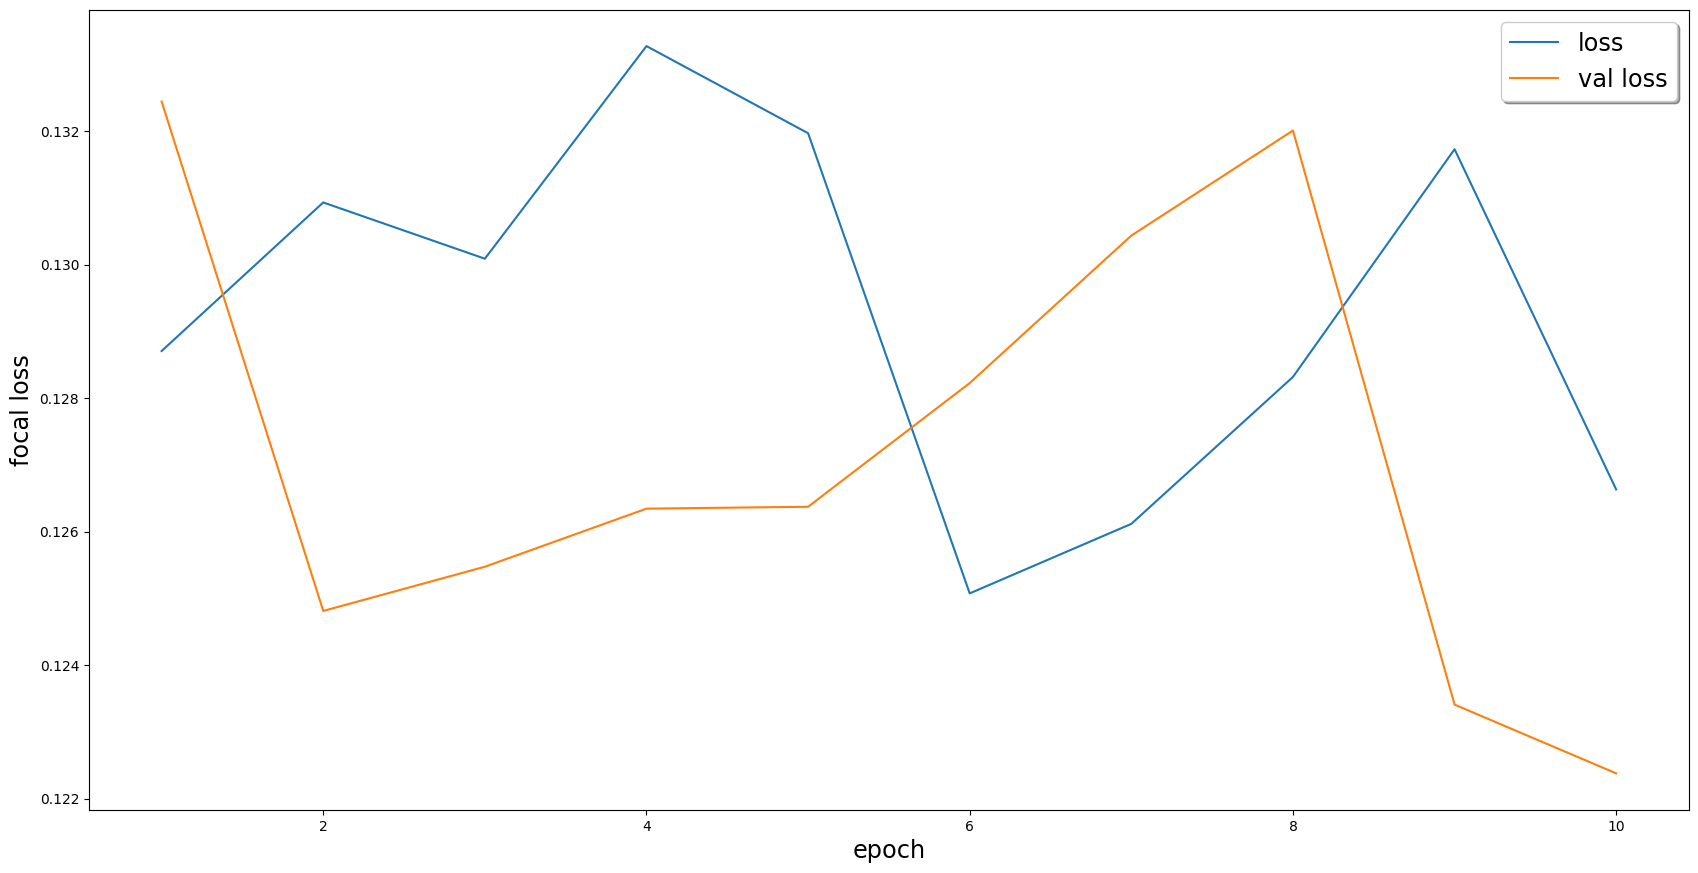

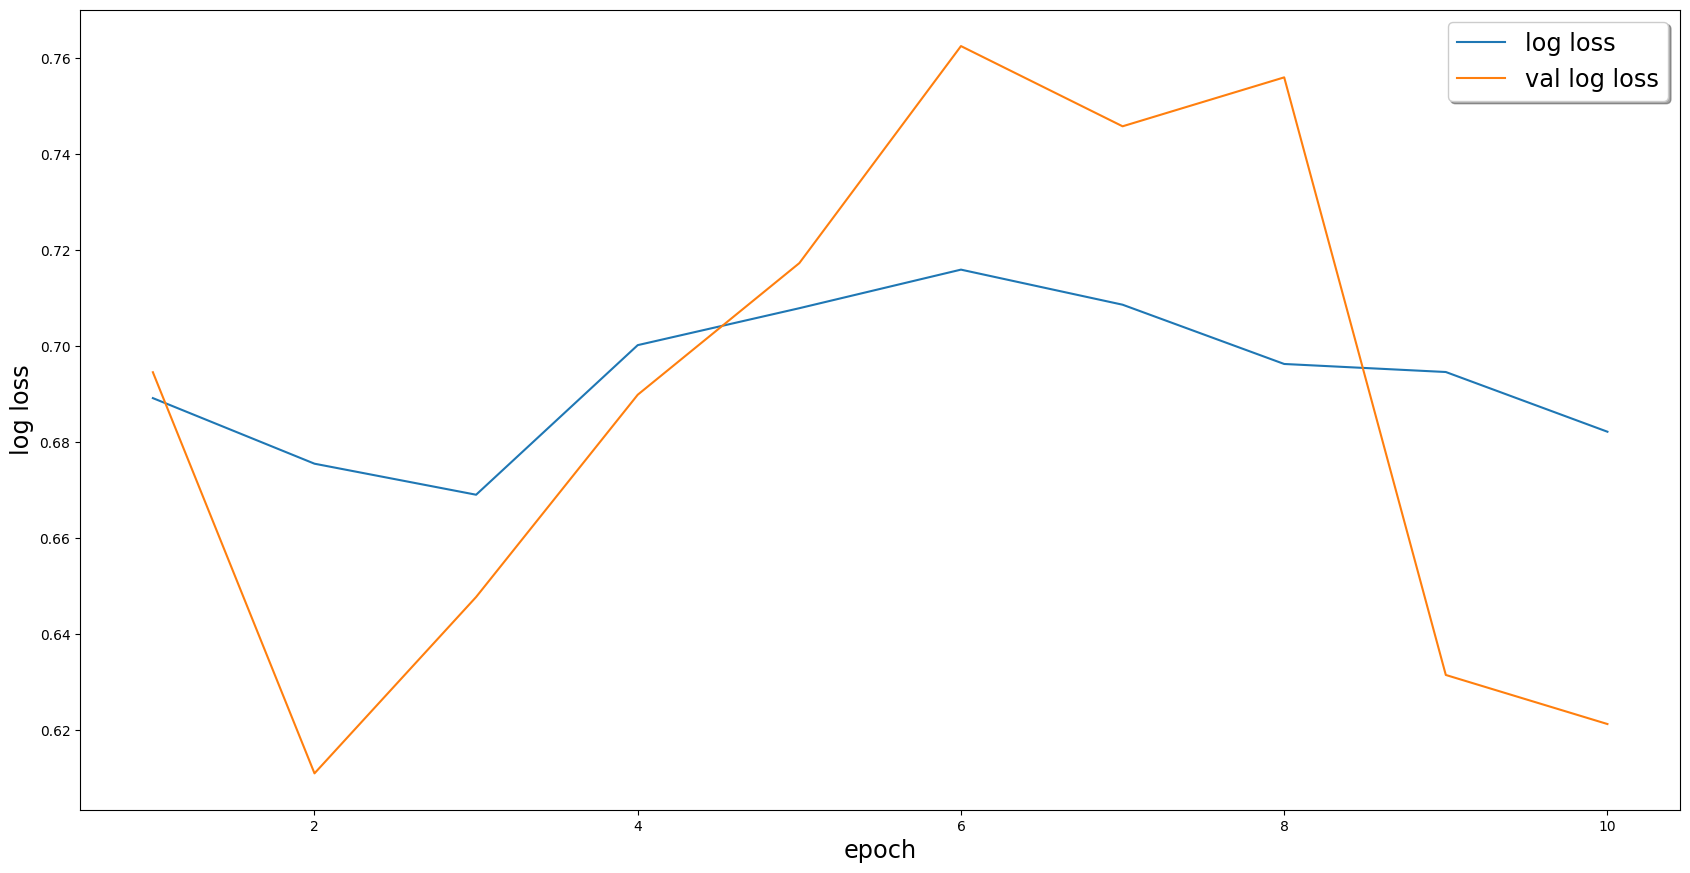

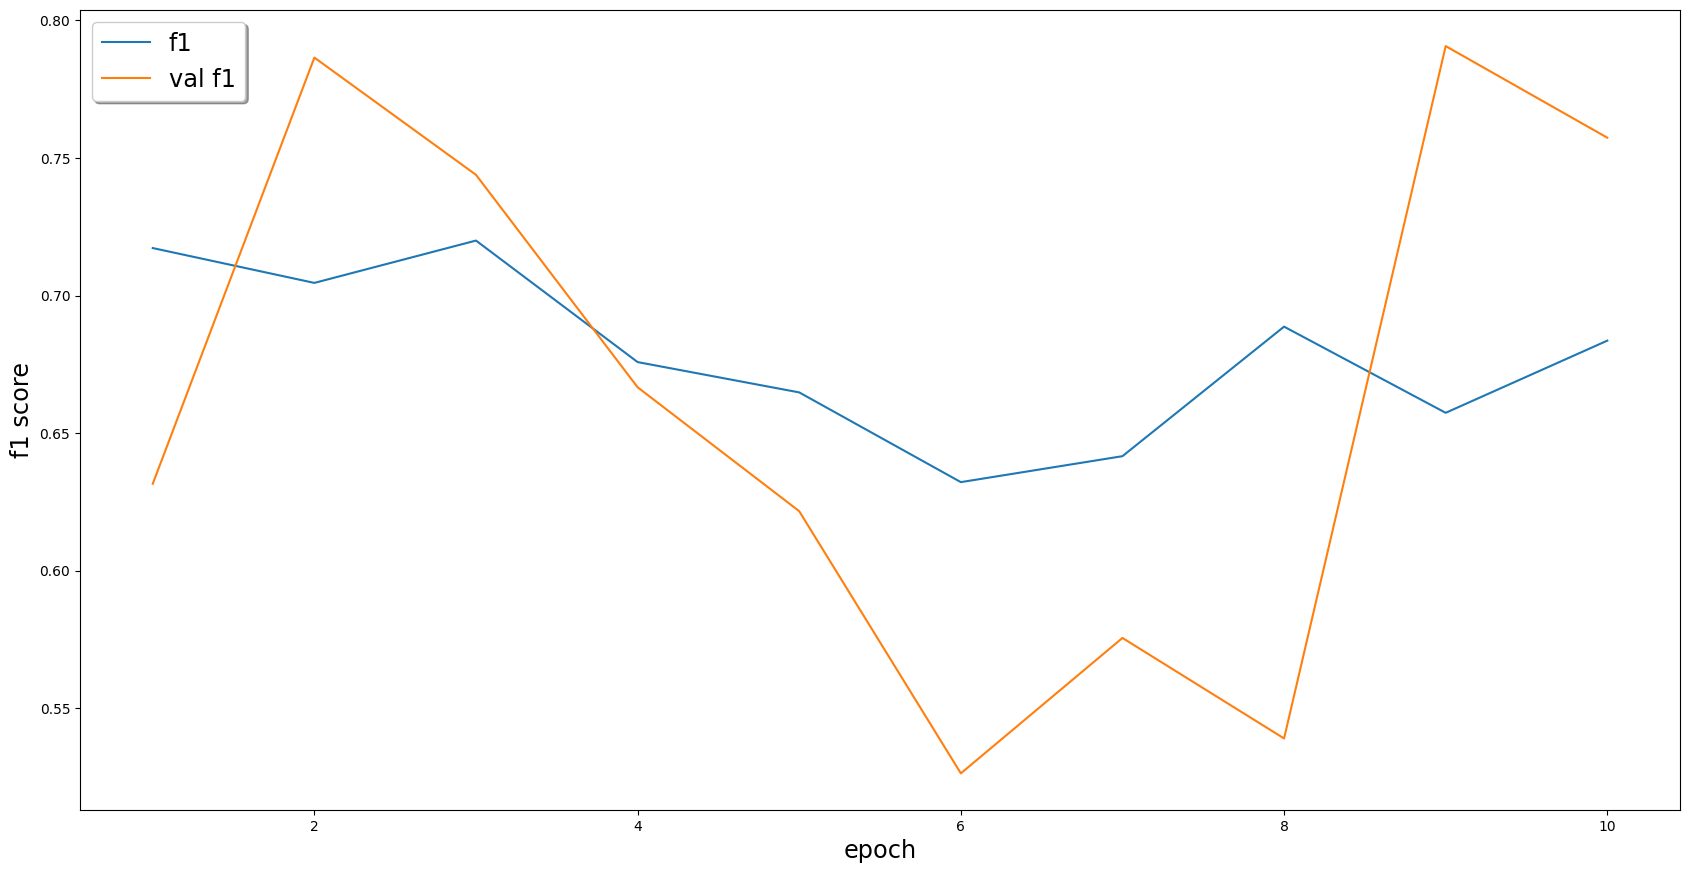

In [96]:
visualize_results(
    losses=losses[:WARM_UP_EPOCHS],
    val_losses=val_losses[:WARM_UP_EPOCHS],
    loglosses=loglosses[:WARM_UP_EPOCHS],
    val_loglosses=val_loglosses[:WARM_UP_EPOCHS],
    f1_scores=f1_scores[:WARM_UP_EPOCHS],
    val_f1_scores=val_f1_scores[:WARM_UP_EPOCHS]
)

In [97]:
classifier.unfreeze_all_layers()

In [98]:
finetune_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=FINE_TUNE_LR)
if os.path.exists(PRETRAINED_MODEL_PATH) and 'finetune_optimizer' in state.keys() and WARM_UP_EPOCHS == 0:
    finetune_optimizer.load_state_dict(state['finetune_optimizer'])

In [107]:
losses[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], val_losses[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], \
loglosses[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], val_loglosses[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], \
f1_scores[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], val_f1_scores[WARM_UP_EPOCHS:WARM_UP_EPOCHS+FINE_TUNE_EPOCHS], \
best_val_loss, best_val_logloss, \
best_model_state_dict, best_optimizer_state_dict \
= train_the_model(
    model=classifier,
    criterion=criterion,
    optimizer=finetune_optimizer,
    epochs=FINE_TUNE_EPOCHS,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    best_val_loss=best_val_loss,
    best_val_logloss=best_val_logloss,
    save_the_best_on='val_logloss'
)

# Save the best checkpoint.
if best_model_state_dict is not None:
    state = {
        'state_dict': best_model_state_dict,
        'finetune_optimizer': best_optimizer_state_dict,
        'best_val_loss': best_val_loss,
        'best_val_logloss': best_val_logloss
    }

    torch.save(state, SAVE_PATH)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12283604012595283 | val loss: 0.12314615957438946 | f1: 0.6799999520946972 | val f1: 0.7407406907483649 | log loss: 0.6844637989997864 | val log loss: 0.6315596699714661


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1198865638838874 | val loss: 0.12330005690455437 | f1: 0.71751407607329 | val f1: 0.7560975107971479 | log loss: 0.6549888253211975 | val log loss: 0.6340842843055725


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1191294797592693 | val loss: 0.12325245700776577 | f1: 0.7085713806497991 | val f1: 0.7484662075802659 | log loss: 0.6568265557289124 | val log loss: 0.6402233242988586


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12249361806445652 | val loss: 0.12286719307303429 | f1: 0.7028570949387788 | val f1: 0.7407406907483649 | log loss: 0.6697691082954407 | val log loss: 0.6245015263557434


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12272436751259698 | val loss: 0.12280712276697159 | f1: 0.6781608717928426 | val f1: 0.7407406907483649 | log loss: 0.6883925795555115 | val log loss: 0.6224187016487122


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12662381099330056 | val loss: 0.12248017080128193 | f1: 0.6529411294359895 | val f1: 0.7407406907483649 | log loss: 0.6820588707923889 | val log loss: 0.6338370442390442


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1211731665664249 | val loss: 0.12268100492656231 | f1: 0.7062146410514253 | val f1: 0.7484662075802659 | log loss: 0.6711098551750183 | val log loss: 0.6288385987281799


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12698142727216086 | val loss: 0.12274207174777985 | f1: 0.6858789148651712 | val f1: 0.7560975107971479 | log loss: 0.6749213933944702 | val log loss: 0.6284657120704651


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12143142273028691 | val loss: 0.12329942733049393 | f1: 0.6840579235118706 | val f1: 0.7560975107971479 | log loss: 0.6742655038833618 | val log loss: 0.6368350386619568


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12106268521812227 | val loss: 0.12276856787502766 | f1: 0.6896551246597998 | val f1: 0.7453415650013535 | log loss: 0.6830976605415344 | val log loss: 0.6378113627433777


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11953064302603404 | val loss: 0.1231965497136116 | f1: 0.6608186662255086 | val f1: 0.7407406907483649 | log loss: 0.6789321899414062 | val log loss: 0.6378070712089539


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12095494568347931 | val loss: 0.12308616377413273 | f1: 0.6744185572404036 | val f1: 0.7560975107971479 | log loss: 0.6699709296226501 | val log loss: 0.6313896775245667


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12121583604150349 | val loss: 0.12318363413214684 | f1: 0.6819483762399356 | val f1: 0.7329192047683378 | log loss: 0.6718340516090393 | val log loss: 0.6437230110168457


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12282625999715593 | val loss: 0.12290004640817642 | f1: 0.6590257401499202 | val f1: 0.7560975107971479 | log loss: 0.6868720650672913 | val log loss: 0.6342669725418091


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1168677881360054 | val loss: 0.12299804203212261 | f1: 0.7179486699458639 | val f1: 0.7636363133737406 | log loss: 0.6667680740356445 | val log loss: 0.6329196691513062


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12271179921097225 | val loss: 0.12227611802518368 | f1: 0.7045454064759846 | val f1: 0.7283950117512608 | log loss: 0.6754329204559326 | val log loss: 0.6211814880371094


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11722248378727171 | val loss: 0.12256017699837685 | f1: 0.6839079982263211 | val f1: 0.7439023888608003 | log loss: 0.6582395434379578 | val log loss: 0.6292258501052856


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12116329371929169 | val loss: 0.12277499958872795 | f1: 0.6472302733928924 | val f1: 0.7439023888608003 | log loss: 0.6856321096420288 | val log loss: 0.6286389827728271


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1214061255256335 | val loss: 0.12292008101940155 | f1: 0.6608186662255086 | val f1: 0.7560975107971479 | log loss: 0.6816392540931702 | val log loss: 0.6267440915107727


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12138756199015512 | val loss: 0.12327488884329796 | f1: 0.7008546528615871 | val f1: 0.7515151012672209 | log loss: 0.6727586388587952 | val log loss: 0.6326659321784973


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12235622604688008 | val loss: 0.12323870696127415 | f1: 0.6876790352624396 | val f1: 0.7590360942517089 | log loss: 0.6769245266914368 | val log loss: 0.6267828345298767


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11861750980218251 | val loss: 0.12259157560765743 | f1: 0.6836157710076958 | val f1: 0.7590360942517089 | log loss: 0.6674689054489136 | val log loss: 0.6085174679756165
Found a better checkpoint!


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11968478477663463 | val loss: 0.12220382690429688 | f1: 0.6860464642103873 | val f1: 0.7515151012672209 | log loss: 0.656342089176178 | val log loss: 0.6030828952789307
Found a better checkpoint!


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1209291203154458 | val loss: 0.1222346480935812 | f1: 0.6744185572404036 | val f1: 0.7283950117512608 | log loss: 0.6665588617324829 | val log loss: 0.6217447519302368


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1188546551598443 | val loss: 0.12258633226156235 | f1: 0.6898550249577852 | val f1: 0.7484662075802659 | log loss: 0.6702913045883179 | val log loss: 0.6296138167381287


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11654728568262523 | val loss: 0.1223723255097866 | f1: 0.6705881882491381 | val f1: 0.7283950117512608 | log loss: 0.6608607769012451 | val log loss: 0.6279510259628296


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12197641366057926 | val loss: 0.12233389541506767 | f1: 0.6918604176953791 | val f1: 0.7329192047683378 | log loss: 0.6541590094566345 | val log loss: 0.6272657513618469


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11744957086112764 | val loss: 0.12258871830999851 | f1: 0.7122506642511051 | val f1: 0.7374999502031282 | log loss: 0.6624776721000671 | val log loss: 0.6348538994789124


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11580425749222438 | val loss: 0.1226201243698597 | f1: 0.6725663247309054 | val f1: 0.7329192047683378 | log loss: 0.6482126712799072 | val log loss: 0.6401869058609009


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12419256733523475 | val loss: 0.12274076044559479 | f1: 0.6705881882491381 | val f1: 0.7484662075802659 | log loss: 0.6727629899978638 | val log loss: 0.6388160586357117


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12412608332104152 | val loss: 0.12276086211204529 | f1: 0.6898550249577852 | val f1: 0.7439023888608003 | log loss: 0.6655263304710388 | val log loss: 0.6299198269844055


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12234882844818963 | val loss: 0.1219727098941803 | f1: 0.6985915010164684 | val f1: 0.7361962689450144 | log loss: 0.6645586490631104 | val log loss: 0.6256226897239685


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11779773152536815 | val loss: 0.1227355245500803 | f1: 0.6627218466440283 | val f1: 0.7407406907483649 | log loss: 0.6666560173034668 | val log loss: 0.6268895268440247


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11728915654950672 | val loss: 0.12289213016629219 | f1: 0.6764705411868545 | val f1: 0.7361962689450144 | log loss: 0.6627645492553711 | val log loss: 0.6198508739471436


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11639906797144148 | val loss: 0.12243055365979671 | f1: 0.6898550249577852 | val f1: 0.7407406907483649 | log loss: 0.6651584506034851 | val log loss: 0.6190468072891235


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1244626094897588 | val loss: 0.1225978285074234 | f1: 0.7078651201868483 | val f1: 0.7484662075802659 | log loss: 0.6804786324501038 | val log loss: 0.6194730997085571


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11901301228337818 | val loss: 0.12316629476845264 | f1: 0.6954022510932785 | val f1: 0.7484662075802659 | log loss: 0.6507928371429443 | val log loss: 0.6253300309181213


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12028542657693227 | val loss: 0.12240485474467278 | f1: 0.6782608220659557 | val f1: 0.7407406907483649 | log loss: 0.6828290224075317 | val log loss: 0.6181251406669617


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11929357879691654 | val loss: 0.12214190699160099 | f1: 0.7222221736049415 | val f1: 0.7407406907483649 | log loss: 0.6690568923950195 | val log loss: 0.623095691204071


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12337208622031742 | val loss: 0.12234236858785152 | f1: 0.6954022510932785 | val f1: 0.7407406907483649 | log loss: 0.6534870266914368 | val log loss: 0.6207442879676819


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11907133625613318 | val loss: 0.12221956066787243 | f1: 0.6988635882973948 | val f1: 0.7329192047683378 | log loss: 0.6684027314186096 | val log loss: 0.6290295720100403


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1165259439084265 | val loss: 0.12199426256120205 | f1: 0.7093022781503546 | val f1: 0.7407406907483649 | log loss: 0.6392974257469177 | val log loss: 0.6156808733940125


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11900730596648322 | val loss: 0.12197532318532467 | f1: 0.6878612240870091 | val f1: 0.7329192047683378 | log loss: 0.6485453248023987 | val log loss: 0.6147441864013672


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11916542384359571 | val loss: 0.12222263775765896 | f1: 0.7045454064759846 | val f1: 0.7407406907483649 | log loss: 0.6516210436820984 | val log loss: 0.6224328279495239


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11633602033058803 | val loss: 0.12174949236214161 | f1: 0.6894586414720691 | val f1: 0.7329192047683378 | log loss: 0.6647055745124817 | val log loss: 0.6243835091590881


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12103874153561062 | val loss: 0.12243659608066082 | f1: 0.6802325107253954 | val f1: 0.7484662075802659 | log loss: 0.6853262186050415 | val log loss: 0.6261340379714966


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12243176665571001 | val loss: 0.12264333106577396 | f1: 0.7082152493062333 | val f1: 0.7560975107971479 | log loss: 0.6516693830490112 | val log loss: 0.6208215951919556


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11934221370352639 | val loss: 0.12213023565709591 | f1: 0.693641570904477 | val f1: 0.7407406907483649 | log loss: 0.6588503122329712 | val log loss: 0.6154791712760925


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11838196052445306 | val loss: 0.12230276875197887 | f1: 0.7118643585623576 | val f1: 0.7407406907483649 | log loss: 0.6599229574203491 | val log loss: 0.622944176197052


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11642570379707548 | val loss: 0.12229600735008717 | f1: 0.6974062923801408 | val f1: 0.7407406907483649 | log loss: 0.6484575271606445 | val log loss: 0.6221765875816345


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12095059040519926 | val loss: 0.12251691520214081 | f1: 0.6743515373502014 | val f1: 0.7407406907483649 | log loss: 0.6692875027656555 | val log loss: 0.6147601008415222


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11494502425193787 | val loss: 0.12232148088514805 | f1: 0.6822156961130172 | val f1: 0.7560975107971479 | log loss: 0.6528392434120178 | val log loss: 0.6200534701347351


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11814934015274048 | val loss: 0.12195503152906895 | f1: 0.7118643585623576 | val f1: 0.7329192047683378 | log loss: 0.6690253615379333 | val log loss: 0.6251017451286316


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11473278204600017 | val loss: 0.12197965197265148 | f1: 0.7159090428331644 | val f1: 0.7329192047683378 | log loss: 0.633526086807251 | val log loss: 0.6191723346710205


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11892779088682598 | val loss: 0.12199033051729202 | f1: 0.718390756827193 | val f1: 0.7329192047683378 | log loss: 0.6409837603569031 | val log loss: 0.6124253869056702


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11687264757023917 | val loss: 0.12198732420802116 | f1: 0.6971428092277583 | val f1: 0.7329192047683378 | log loss: 0.6580601334571838 | val log loss: 0.616889476776123


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11366803778542413 | val loss: 0.12255147285759449 | f1: 0.7392549664649745 | val f1: 0.7407406907483649 | log loss: 0.6387468576431274 | val log loss: 0.6169689297676086


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11492778857549031 | val loss: 0.1221722699701786 | f1: 0.7122506642511051 | val f1: 0.7329192047683378 | log loss: 0.6218793392181396 | val log loss: 0.6063224077224731


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11024355391661327 | val loss: 0.12255875580012798 | f1: 0.7713498134371545 | val f1: 0.7283950117512608 | log loss: 0.6181550621986389 | val log loss: 0.6081026792526245


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11713022738695145 | val loss: 0.12250823527574539 | f1: 0.7215908610117542 | val f1: 0.7407406907483649 | log loss: 0.6431851983070374 | val log loss: 0.6168704032897949


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11510196245378918 | val loss: 0.12266888096928596 | f1: 0.7211267122713779 | val f1: 0.7374999502031282 | log loss: 0.6513848304748535 | val log loss: 0.6390926837921143


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11658512718147701 | val loss: 0.12193694151937962 | f1: 0.7138809716826264 | val f1: 0.7329192047683378 | log loss: 0.6458260416984558 | val log loss: 0.6211426258087158


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11811861644188563 | val loss: 0.12191898562014103 | f1: 0.7236466756406228 | val f1: 0.7329192047683378 | log loss: 0.6433333158493042 | val log loss: 0.6143017411231995


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11964681496222813 | val loss: 0.12225359119474888 | f1: 0.6762177172174316 | val f1: 0.7407406907483649 | log loss: 0.6900877356529236 | val log loss: 0.6308983564376831


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1131641376349661 | val loss: 0.12221851944923401 | f1: 0.6976743711803709 | val f1: 0.7329192047683378 | log loss: 0.6433932781219482 | val log loss: 0.6229621171951294


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12478797054953045 | val loss: 0.121917724609375 | f1: 0.7242339347304911 | val f1: 0.7484662075802659 | log loss: 0.6571057438850403 | val log loss: 0.6137306094169617


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1182420618004269 | val loss: 0.12159185484051704 | f1: 0.7179486699458639 | val f1: 0.7484662075802659 | log loss: 0.6408804059028625 | val log loss: 0.6086940765380859


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11587995373540455 | val loss: 0.12172084301710129 | f1: 0.718390756827193 | val f1: 0.7484662075802659 | log loss: 0.6350638270378113 | val log loss: 0.6011186242103577
Found a better checkpoint!


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11768114566802979 | val loss: 0.1220558863133192 | f1: 0.7048710123299512 | val f1: 0.7530863697454688 | log loss: 0.6501261591911316 | val log loss: 0.6078273057937622


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1144885164168146 | val loss: 0.12223250977694988 | f1: 0.7065526585563461 | val f1: 0.7530863697454688 | log loss: 0.6425712704658508 | val log loss: 0.6189114451408386


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1211689520213339 | val loss: 0.12157861143350601 | f1: 0.6898550249577852 | val f1: 0.7484662075802659 | log loss: 0.6477956175804138 | val log loss: 0.6118970513343811


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1167597042189704 | val loss: 0.12213906832039356 | f1: 0.7159090428331644 | val f1: 0.7439023888608003 | log loss: 0.6362138986587524 | val log loss: 0.6012895107269287


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12190896355443531 | val loss: 0.1222305428236723 | f1: 0.7242339347304911 | val f1: 0.7439023888608003 | log loss: 0.6377599835395813 | val log loss: 0.6091786026954651


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11201548907491896 | val loss: 0.12212153524160385 | f1: 0.7277936484199669 | val f1: 0.7407406907483649 | log loss: 0.6167186498641968 | val log loss: 0.6152833104133606


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11684473107258479 | val loss: 0.12176294811069965 | f1: 0.7048710123299512 | val f1: 0.7484662075802659 | log loss: 0.6433613896369934 | val log loss: 0.6021670699119568


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12001228415303761 | val loss: 0.12145425006747246 | f1: 0.7353759960056208 | val f1: 0.7439023888608003 | log loss: 0.6333903670310974 | val log loss: 0.5998842716217041
Found a better checkpoint!


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12302616321378285 | val loss: 0.12174688838422298 | f1: 0.6951566471668281 | val f1: 0.7361962689450144 | log loss: 0.6598573327064514 | val log loss: 0.6056467890739441


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.118512904478444 | val loss: 0.12193841300904751 | f1: 0.7014492278496147 | val f1: 0.7329192047683378 | log loss: 0.6587586998939514 | val log loss: 0.6242021918296814


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11340602570109898 | val loss: 0.12176743149757385 | f1: 0.7126436303937144 | val f1: 0.7453415650013535 | log loss: 0.6240420341491699 | val log loss: 0.6220386624336243


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12404870490233104 | val loss: 0.1215794775635004 | f1: 0.7282912680962612 | val f1: 0.7484662075802659 | log loss: 0.6506553888320923 | val log loss: 0.5997371077537537
Found a better checkpoint!


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1132526041732894 | val loss: 0.12251918762922287 | f1: 0.7215908610117542 | val f1: 0.7283950117512608 | log loss: 0.6349700093269348 | val log loss: 0.6093612909317017


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11623428265253703 | val loss: 0.12215514294803143 | f1: 0.701149377526757 | val f1: 0.7374999502031282 | log loss: 0.6558557152748108 | val log loss: 0.6251651644706726


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11011179619365269 | val loss: 0.12217622064054012 | f1: 0.7415729853364504 | val f1: 0.7407406907483649 | log loss: 0.6194904446601868 | val log loss: 0.6123409867286682


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11650773965650135 | val loss: 0.12164567038416862 | f1: 0.7159090428331644 | val f1: 0.7484662075802659 | log loss: 0.6362402439117432 | val log loss: 0.5999125838279724


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11355560935205883 | val loss: 0.12227746099233627 | f1: 0.7231637935842223 | val f1: 0.7453415650013535 | log loss: 0.6337577700614929 | val log loss: 0.6252039074897766


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11242372045914333 | val loss: 0.12208184599876404 | f1: 0.7450979907759212 | val f1: 0.7374999502031282 | log loss: 0.6312309503555298 | val log loss: 0.6375839114189148


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11398104247119692 | val loss: 0.12196747958660126 | f1: 0.7513811667165259 | val f1: 0.7329192047683378 | log loss: 0.633813202381134 | val log loss: 0.6094934344291687


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11623148537344402 | val loss: 0.12168588116765022 | f1: 0.7415729853364504 | val f1: 0.7329192047683378 | log loss: 0.6375216245651245 | val log loss: 0.6151540875434875


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11987016846736272 | val loss: 0.12181008607149124 | f1: 0.7025495269298397 | val f1: 0.7329192047683378 | log loss: 0.6410121321678162 | val log loss: 0.614276111125946


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11947911812199487 | val loss: 0.12137149088084698 | f1: 0.7078651201868483 | val f1: 0.7374999502031282 | log loss: 0.6495813131332397 | val log loss: 0.6154069900512695


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11900555921925439 | val loss: 0.12117846682667732 | f1: 0.7329544973689338 | val f1: 0.7407406907483649 | log loss: 0.6519140005111694 | val log loss: 0.6058151721954346


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1132448563973109 | val loss: 0.12137965485453606 | f1: 0.7062146410514253 | val f1: 0.7407406907483649 | log loss: 0.6274331212043762 | val log loss: 0.6092047095298767


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11348133616977268 | val loss: 0.12168271094560623 | f1: 0.7616437866886876 | val f1: 0.7361962689450144 | log loss: 0.6289386749267578 | val log loss: 0.6042794585227966


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.12170525723033482 | val loss: 0.12221367098391056 | f1: 0.7138809716826264 | val f1: 0.7407406907483649 | log loss: 0.6451898217201233 | val log loss: 0.6056392192840576


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11751215491029951 | val loss: 0.12219478189945221 | f1: 0.737142809204901 | val f1: 0.7407406907483649 | log loss: 0.6367627382278442 | val log loss: 0.614046037197113


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11472491257720524 | val loss: 0.12243730016052723 | f1: 0.71751407607329 | val f1: 0.7407406907483649 | log loss: 0.6436851620674133 | val log loss: 0.6147339940071106


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11613183385796017 | val loss: 0.12263325788080692 | f1: 0.7062146410514253 | val f1: 0.7407406907483649 | log loss: 0.6528778672218323 | val log loss: 0.6253418922424316


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.1124313473701477 | val loss: 0.12224416062235832 | f1: 0.7082152493062333 | val f1: 0.7374999502031282 | log loss: 0.6280586123466492 | val log loss: 0.6235819458961487


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11124420248799854 | val loss: 0.12193180434405804 | f1: 0.7528089403863178 | val f1: 0.7329192047683378 | log loss: 0.6178992390632629 | val log loss: 0.6143385171890259


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

loss: 0.11453155510955387 | val loss: 0.12215837650001049 | f1: 0.7430167112730596 | val f1: 0.7407406907483649 | log loss: 0.6177307367324829 | val log loss: 0.6109768152236938


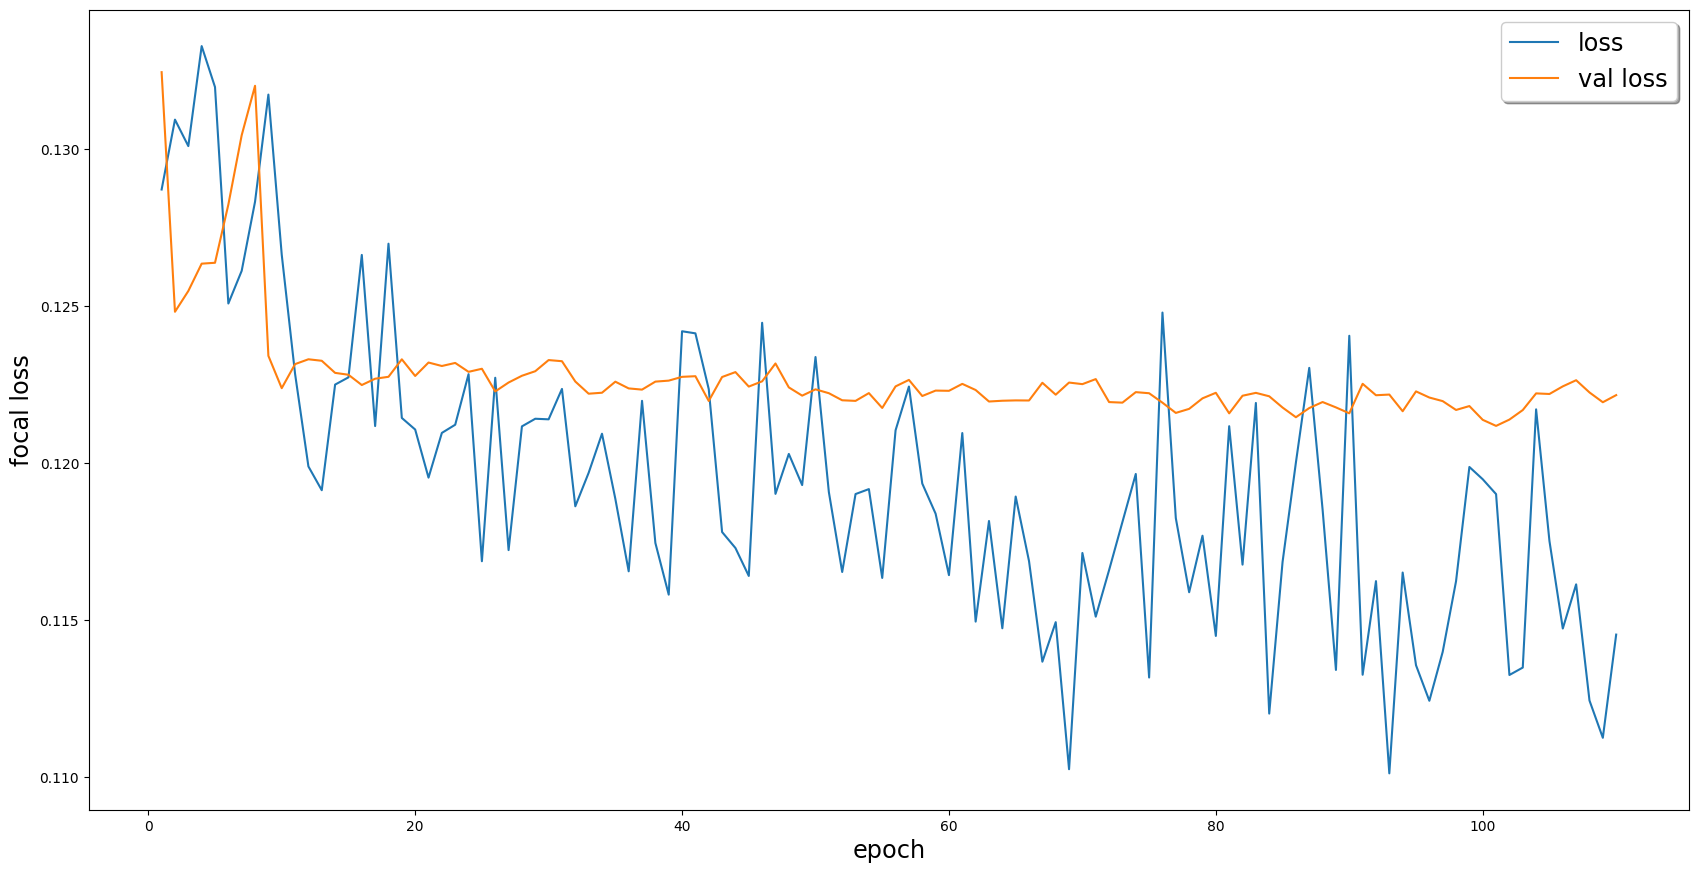

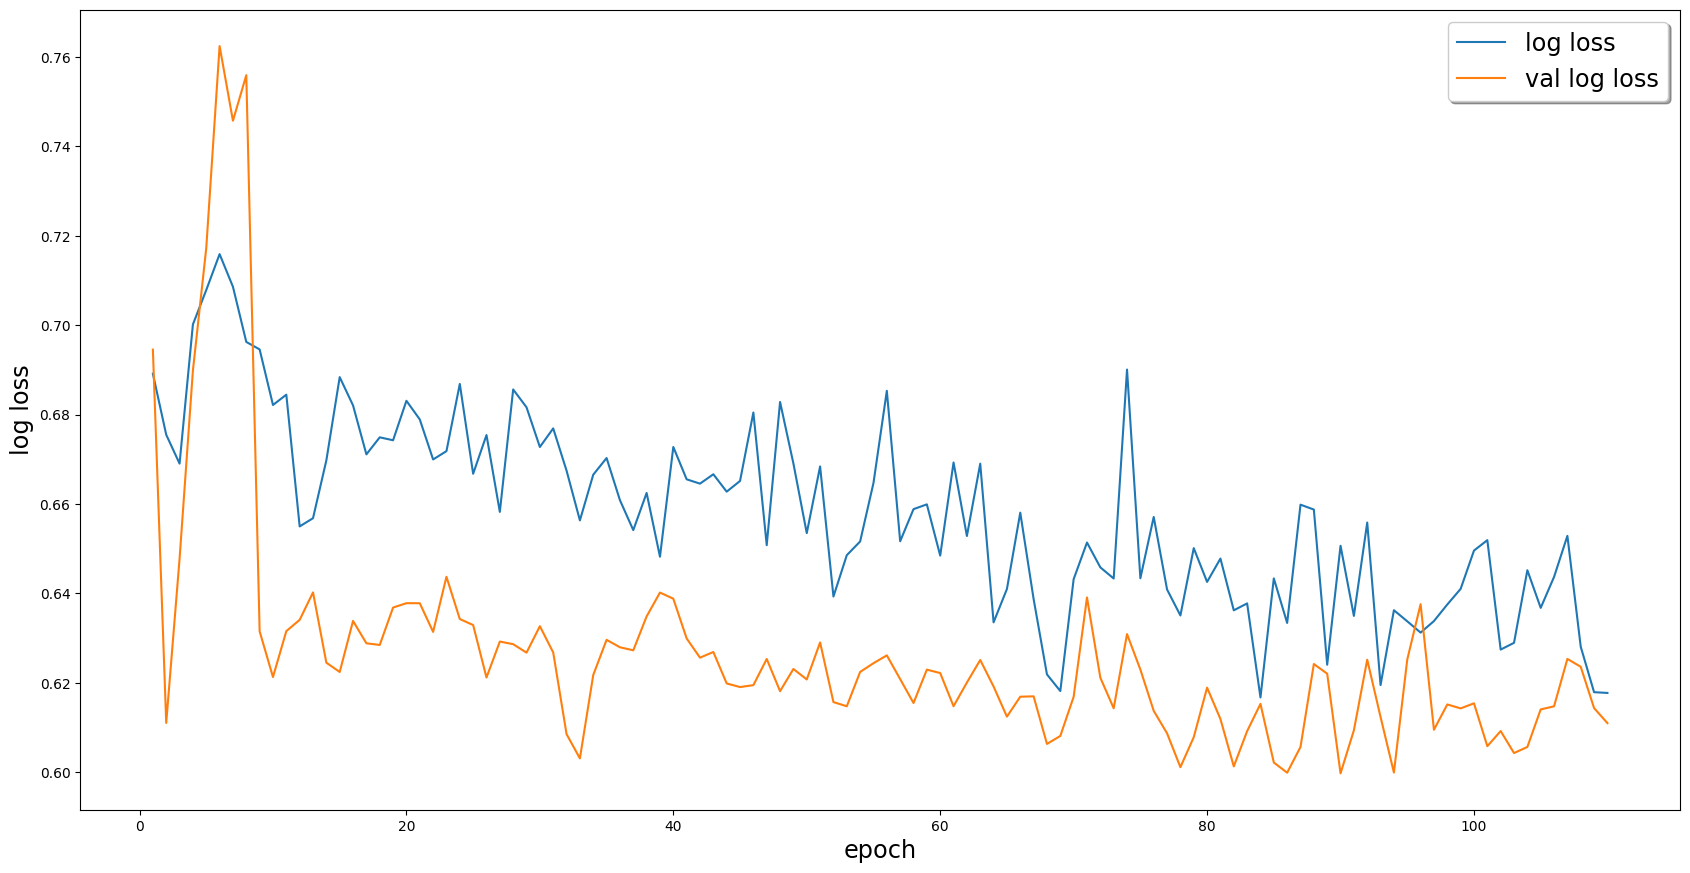

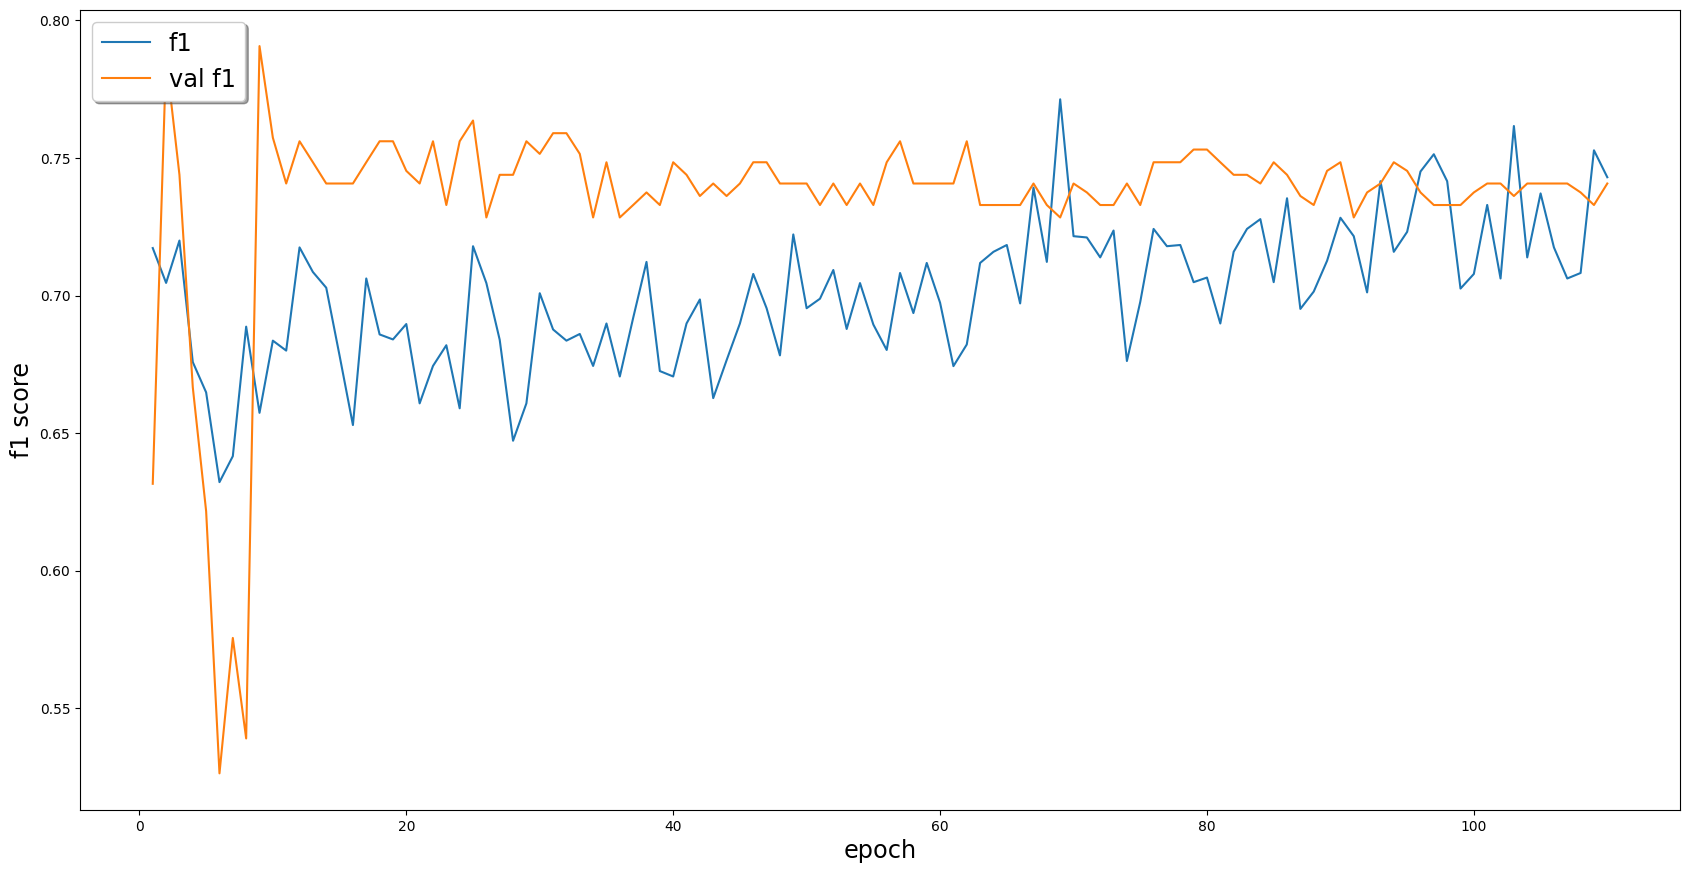

In [108]:
visualize_results(
    losses=losses,
    val_losses=val_losses,
    loglosses=loglosses,
    val_loglosses=val_loglosses,
    f1_scores=f1_scores,
    val_f1_scores=val_f1_scores
)